In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import isnan, when, count, col
#from pyspark.ml.regression import LabeledPoint
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import NaiveBayesModel
from pyspark.ml.linalg import Vector, SparseVector, DenseVector, Matrices
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("BetsExploring").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=BetsExploring>

In [3]:
betsHouses = ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'WH']
quotaTypes = ['H','D','A']
accuracyList = []

In [4]:
# Selecting fields included in dataframe to use as features

def calcBetsHousesCols(df, betsHouses):
    betsHousesCols = []
    betsHousesOk = []
    for betsHouse in betsHouses:
        col = betsHouse + 'H'
        if col in df.columns:
            betsHousesOk.append(betsHouse)
            betsHousesCols.append(betsHouse + 'H')
            betsHousesCols.append(betsHouse + 'D')
            betsHousesCols.append(betsHouse + 'A')

    print ("Potential bets houses:", betsHouses)
    print ("Bets houses selected :" , betsHousesOk)
    print ("Bets houses columns  :", betsHousesCols)
    
    return betsHousesCols

In [5]:
# Cleaning nulls in dataframe, mixing deletion of columns and rows
# Columns with less than 'percDropping' not null rows will be deleted
# Rows with nulls aftes deleting columns will be deleted

def cleanNulls(df, percDropping):
    print ("Cleaning nulls:")
    totalrows = df.count()
    notnullrows = df.dropna().count()
    dropCols = []
    print ("Total rows:", totalrows)
    print ("Not null rows: ", notnullrows)
    print ("Percentage for dropping column: ", percDropping, "%")

    print ("\nNot null rows before cleaning:")
    dfok = df
    for col in df.columns:

        percOk = round((df.select(col).dropna().count() / totalrows) * 100, 2)
        print (col, "\t", df.select(col).dropna().count(), "\t(", percOk, "%)")

        # Dropping columnss with a lot of nulls
        if percOk < percDropping:
            dropCols.append(col)
            dfok = dfok.drop(col)
    #        print ("\tColumn dropped")

    # Dropping row with nulls
    dfok = dfok.dropna()
    percOk = round((dfok.count() / totalrows) * 100 , 2)
    print ("\nDropped columns:", dropCols)
    print ("Not null rows after cleaning: " , dfok.count(), "\t(", percOk, "%)")
    print ("Final columns:", dfok.columns)
    
    return dfok

In [6]:
# Converting text result to numeric result

def resultToNumeric(df):
    dfok = df.withColumn("Label", when(df['FTR']=='H',0)
                             .when(df['FTR']=='D',1)
                             .when(df['FTR']=='A',2).cast("double"))
    dfok.show(3)
                      
    return dfok

In [7]:
# Create Dataframe with label and features 

def createLabelAndFeatures(df, betsHousesCols):
    vectorAssembler = VectorAssembler(
        inputCols = betsHousesCols, 
        outputCol = 'features')

    vec_df = vectorAssembler.transform(df)

    vec_df = vec_df.withColumn("label", df["Label"])

    vec_df = vec_df.select(['features', 'label'])
    vec_df.show(5, False)
    vec_df.printSchema()
    
    return vec_df

In [8]:
# Defining, Training and Avaluating Naive Bayes Model

def calcNaiveBayesModel(df, betsHousesCols):
    
    # Converting result to numeric
    print ("\n  - Converting result to numeric")
    df = resultToNumeric(df)

    # Creating vector with label and features for training
    print ("\n  - Creating vector with label and features for training")
    vectrain = createLabelAndFeatures(df, betsHousesCols)

    # Training model
    print ("\n  - Training model")
    nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
    model = nb.fit(vectrain)
    print("Pi   :", model.pi)
    print("Theta:", model.theta)

    # Calculating auto-prediction to avaluate model
    print ("\n  - Calculating auto-prediction to avaluate model")
    predict_train = model.transform(vectrain)
    predict_train.show(5, False)

    # Evaluating model
    print ("\n  - Evaluating model")
    nb_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")
    accuracy = nb_evaluator.evaluate(predict_train)
    print ("Accuracy: ", round(accuracy * 100, 2), "%")
    
    return (model, accuracy)

In [9]:
# Calculating predictions with test dataset
def calcPrediction (model, df, betsHousesCols):
    
    # Converting result to numeric
    print ("\n  - Converting result to numeric")
    df = resultToNumeric(df)

    # Creating vector with label and features for training
    print ("  - Creating vector with label and features for training")
    vectest = createLabelAndFeatures(df, betsHousesCols)

    # Calculating prediction
    print ("  - Calculating prediction")
    predict = model.transform(vectest)
    print(predict.count())
    predict.show(5, False)

    # Evaluating test
    print ("  - Evaluating model")
    nb_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")
    accuracy = nb_evaluator.evaluate(predict)
    print ("Accuracy: ", round(accuracy * 100, 2), "%")
    
    return (predict, accuracy)

In [10]:
# Calculating Naive Bayes Model and Prediction

def calcModelAndPrediction(df):
    
    # Cleaning nulls in columns and rows
    print ("\n* Cleaning nulls in columns and rows")
    dfok = cleanNulls(df, 80)

    # Calculating Bets Houses Cols
    print ("\n  - Calculating Bets Houses Cols")
    betsHousesCols =  calcBetsHousesCols(dfok, betsHouses)

    # Spliting training and testing datasets
    print ("\n* Spliting training and testing datasets")
    dftrain, dftest = dfok.randomSplit([0.8, 0.2], seed=1)
    print("  Train dataset:", dftrain.count(), "rows")
    print("  Test dataset: ", dftest.count(), "rows")

    # Defining, Training and Avaluating Naive Bayes Model
    print ("\n* Defining, Training and Avaluating Naive Bayes Model")
    (model, modelAccuracy) = calcNaiveBayesModel(dftrain, betsHousesCols)

    # Calculating predictions with test dataset
    print ("\n* Calculating predictions with test dataset")
    (predict, predictAccuracy) = calcPrediction(model, dftest, betsHousesCols)

    return (modelAccuracy, predictAccuracy)

In [11]:
url = "../Data/Processed/main_competitions_recent.csv"
# Open Dataset file
print ("* Opening dataset file")
df = spark.read.csv(path = url, header = True, inferSchema = True)
print ("Rows   :", df.count())
print ("First row:")
print(df.take(1))
df.printSchema()


* Opening dataset file
Rows   : 11374
First row:
[Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 28, 0, 0), HomeTeam='Antwerp', AwayTeam='Anderlecht', FTR='D', B365H=5.75, B365D=3.8, B365A=1.6, BWH=5.0, BWD=4.0, BWA=1.67, IWH=4.7, IWD=3.6, IWA=1.7, LBH=5.2, LBD=3.7, LBA=1.61, VCH=5.5, VCD=3.9, VCA=1.62, WHH=4.75, WHD=3.75, WHA=1.67, Divergence=11.65048543689322)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |

In [44]:
labelList = []
modelList = []
predictList = []
minDiver = 4.31
maxDiver = 14.06

In [45]:
# 10% lower divergences matches (<4.31%)
dfMinDiver = df.filter(df["Divergence"] < minDiver)
print ("Rows   :", dfMinDiver.count())
print ("First row:")
print(dfMinDiver.take(1))
dfMinDiver.printSchema()

(modelAccuracy, predictAccuracy) = calcModelAndPrediction(dfMinDiver)

labelList.append(0.1)
modelList.append(modelAccuracy)
predictList.append(predictAccuracy)

Rows   : 1135
First row:
[Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 29, 0, 0), HomeTeam='Eupen', AwayTeam='Waregem', FTR='A', B365H=2.6, B365D=3.4, B365A=2.6, BWH=2.7, BWD=3.4, BWA=2.6, IWH=2.65, IWD=3.3, IWA=2.5, LBH=2.55, LBD=3.3, LBA=2.5, VCH=2.63, VCD=3.4, VCA=2.6, WHH=2.6, WHD=3.4, WHA=2.5, Divergence=2.9879211697393604)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |-- IWD: double (nullable = true)

+-------------------------------------------------------------------+-----+
|features                                                           |label|
+-------------------------------------------------------------------+-----+
|[2.29,3.39,3.0,2.4,3.4,2.95,2.3,3.3,2.9,2.38,3.4,2.88,2.25,3.3,3.0]|0.0  |
|[2.54,3.39,2.62,2.6,3.4,2.55,2.6,3.2,2.6,2.6,3.4,2.63,2.6,3.25,2.6]|2.0  |
|[2.1,3.5,3.25,2.2,3.5,3.25,2.1,3.3,3.3,2.2,3.5,3.13,2.1,3.5,3.1]   |2.0  |
|[2.14,3.4,3.3,2.15,3.6,3.25,2.15,3.45,3.1,2.2,3.4,3.2,2.15,3.5,3.1]|0.0  |
|[1.9,3.6,3.75,1.91,3.8,3.75,1.87,3.7,3.6,1.9,3.8,3.7,1.88,3.9,3.6] |1.0  |
+-------------------------------------------------------------------+-----+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

  - Calculating prediction
231
+-------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------

In [46]:
dfMidDiver = df.filter(df["Divergence"] > minDiver).filter(df["Divergence"] < maxDiver)
print ("Rows   :", dfMidDiver.count())
print ("First row:")
print(dfMidDiver.take(1))
dfMidDiver.printSchema()

(modelAccuracy, predictAccuracy) = calcModelAndPrediction(dfMidDiver)

labelList.append(0.5)
modelList.append(modelAccuracy)
predictList.append(predictAccuracy)

Rows   : 9099
First row:
[Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 7, 28, 0, 0), HomeTeam='Antwerp', AwayTeam='Anderlecht', FTR='D', B365H=5.75, B365D=3.8, B365A=1.6, BWH=5.0, BWD=4.0, BWA=1.67, IWH=4.7, IWD=3.6, IWA=1.7, LBH=5.2, LBD=3.7, LBA=1.61, VCH=5.5, VCD=3.9, VCA=1.62, WHH=4.75, WHD=3.75, WHA=1.67, Divergence=11.65048543689322)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |-- IWD: double (nullable

+--------------------------------------------------------------------+-----+
|features                                                            |label|
+--------------------------------------------------------------------+-----+
|[3.1,3.5,2.2,3.4,3.4,2.15,3.2,3.4,2.1,3.13,3.5,2.2,3.25,3.4,2.1]    |0.0  |
|[2.2,3.3,3.25,2.3,3.2,3.3,2.3,3.3,2.9,2.25,3.4,3.1,2.2,3.3,3.1]     |0.0  |
|[1.75,3.75,4.33,1.83,3.7,4.25,1.85,3.5,3.9,1.87,3.6,4.0,1.8,3.5,4.2]|0.0  |
|[2.0,3.39,3.75,2.0,3.6,3.7,2.1,3.3,3.3,2.0,3.7,3.5,2.0,3.75,3.2]    |0.0  |
|[1.62,3.75,5.5,1.67,3.7,5.5,1.6,3.7,5.4,1.65,3.8,5.25,1.65,3.75,4.8]|0.0  |
+--------------------------------------------------------------------+-----+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

  - Calculating prediction
1855
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+-----------------------------

In [47]:
# 10% higher divergence matches (> 14,06%)
dfMaxDiver = df.filter(df["Divergence"] > maxDiver)
print ("Rows   :", dfMaxDiver.count())
print ("First row:")
print(dfMaxDiver.take(1))
dfMaxDiver.printSchema()

(modelAccuracy, predictAccuracy) = calcModelAndPrediction(dfMaxDiver)

labelList.append(0.9)
modelList.append(modelAccuracy)
predictList.append(predictAccuracy)

Rows   : 1140
First row:
[Row(Country='Belgium', Competition='JupilerLeague', Season='2017-2018', Div='B1', Date=datetime.datetime(2017, 6, 8, 0, 0), HomeTeam='Club Brugge', AwayTeam='Eupen', FTR='H', B365H=1.22, B365D=5.75, B365A=13.0, BWH=1.26, BWD=6.25, BWA=10.5, IWH=1.25, IWD=5.5, IWA=10.3, LBH=1.22, LBD=5.8, LBA=12.0, VCH=1.22, VCD=6.25, VCA=12.0, WHH=1.25, WHD=5.5, WHA=10.0, Divergence=15.04424778761062)]
root
 |-- Country: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Div: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTR: string (nullable = true)
 |-- B365H: double (nullable = true)
 |-- B365D: double (nullable = true)
 |-- B365A: double (nullable = true)
 |-- BWH: double (nullable = true)
 |-- BWD: double (nullable = true)
 |-- BWA: double (nullable = true)
 |-- IWH: double (nullable = true)
 |-- IWD: double (nu

+-------+-------------+---------+---+-------------------+-----------+--------+---+-----+-----+-----+----+---+----+----+---+---+----+---+---+----+---+---+------------------+-----+
|Country|  Competition|   Season|Div|               Date|   HomeTeam|AwayTeam|FTR|B365H|B365D|B365A| BWH|BWD| BWA| IWH|IWD|IWA| VCH|VCD|VCA| WHH|WHD|WHA|        Divergence|Label|
+-------+-------------+---------+---+-------------------+-----------+--------+---+-----+-----+-----+----+---+----+----+---+---+----+---+---+----+---+---+------------------+-----+
|Belgium|JupilerLeague|2017-2018| B1|2017-08-27 00:00:00|Club Brugge|Standard|  H| 1.73|  3.4| 5.25|1.75|3.9| 4.5| 1.7|3.6|4.7|1.75|3.7|4.6| 1.8|3.6|4.0|15.596330275229352|  0.0|
|Belgium|JupilerLeague|2017-2018| B1|2017-10-15 00:00:00|   Standard|Kortrijk|  H| 1.44|  4.2|  7.5|1.48|4.5|6.75| 1.6|3.9|5.0|1.45|4.4|7.0| 1.5|4.0|6.0|22.580645161290313|  0.0|
|Belgium|JupilerLeague|2017-2018| B1|2017-12-23 00:00:00|       Genk|Kortrijk|  A| 1.44|  4.2|  7.5| 1.5|

In [48]:
print (labelList)
print (modelList)
print (predictList)

[0.1, 0.5, 0.9]
[0.4018058690744921, 0.49354614850798056, 0.6972067039106146]
[0.3939393939393939, 0.4555256064690027, 0.6939655172413793]


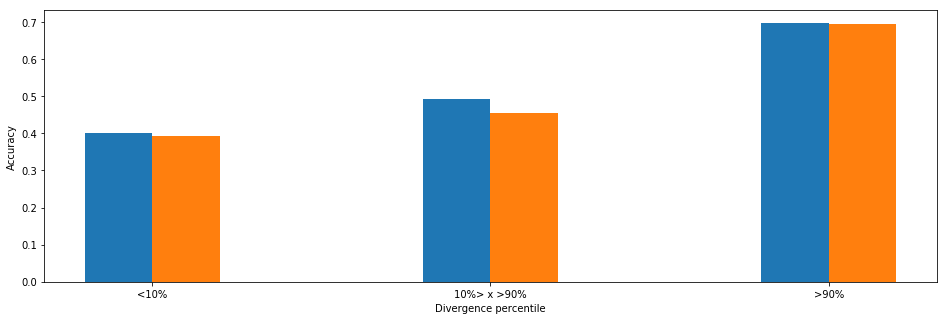

In [52]:
# Accuracy by divergence range

fig, ax = plt.subplots(figsize=[16,5])

index = np.arange(3)
bar_width = 0.2
plt.bar(index - bar_width/2, modelList, bar_width)
plt.bar(index + bar_width/2, predictList, bar_width)

ax.set_xticks(index)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Divergence percentile")
ax.set_xticklabels(('<10%', '10%> x >90%', '>90%'))
plt.show()

In [92]:
# Calculating accuracy for model and test in all the quantiles of Divergence
labelList = []
modelList = []
predictList = []

# Calculating quantiles of divergence
percenList = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9]
dfdiver = df.select('Divergence')
quantileList = dfdiver.approxQuantile('Divergence',percenList,0)
print (quantileList)

prevQuantile = 0
cont = 0
for quantile in quantileList:
    dfPercen = df.filter(df["Divergence"] >= prevQuantile).filter(df["Divergence"] < quantile)
    print ("* Quantile: ", percenList[cont], ", Divergence: ", quantile, ", Rows: ", dfPercen.count())

    (modelAccuracy, predictAccuracy) = calcModelAndPrediction(dfPercen)

    labelList.append(percenList[cont])
    modelList.append(modelAccuracy)
    predictList.append(predictAccuracy)
    
    prevQuantile = quantile
    cont+=1

[4.311543810848395, 5.109489051094895, 5.714285714285716, 6.329113924050644, 6.976744186046513, 7.801418439716324, 8.910891089108919, 10.658307210031326, 14.0625]
* Quantile:  0.1 , Divergence:  4.311543810848395 , Rows:  1137

* Cleaning nulls in columns and rows
Cleaning nulls:
Total rows: 1137
Not null rows:  495
Percentage for dropping column:  80 %

Not null rows before cleaning:
Country 	 1137 	( 100.0 %)
Competition 	 1137 	( 100.0 %)
Season 	 1137 	( 100.0 %)
Div 	 1137 	( 100.0 %)
Date 	 1137 	( 100.0 %)
HomeTeam 	 1137 	( 100.0 %)
AwayTeam 	 1137 	( 100.0 %)
FTR 	 1137 	( 100.0 %)
B365H 	 1131 	( 99.47 %)
B365D 	 1131 	( 99.47 %)
B365A 	 1131 	( 99.47 %)
BWH 	 1131 	( 99.47 %)
BWD 	 1131 	( 99.47 %)
BWA 	 1131 	( 99.47 %)
IWH 	 1129 	( 99.3 %)
IWD 	 1129 	( 99.3 %)
IWA 	 1129 	( 99.3 %)
LBH 	 498 	( 43.8 %)
LBD 	 498 	( 43.8 %)
LBA 	 498 	( 43.8 %)
VCH 	 1130 	( 99.38 %)
VCD 	 1130 	( 99.38 %)
VCA 	 1130 	( 99.38 %)
WHH 	 1131 	( 99.47 %)
WHD 	 1131 	( 99.47 %)
WHA 	 1131 	( 

+-------------------------------------------------------------------+-----+
|features                                                           |label|
+-------------------------------------------------------------------+-----+
|[2.29,3.39,3.0,2.4,3.4,2.95,2.3,3.3,2.9,2.38,3.4,2.88,2.25,3.3,3.0]|0.0  |
|[2.79,3.39,2.39,2.85,3.4,2.45,2.75,3.3,2.4,2.8,3.5,2.4,2.7,3.4,2.4]|0.0  |
|[3.25,3.39,2.14,3.3,3.3,2.15,3.3,3.3,2.1,3.13,3.5,2.2,3.1,3.4,2.15]|0.0  |
|[2.54,3.29,2.7,2.6,3.5,2.6,2.5,3.3,2.65,2.55,3.5,2.63,2.6,3.25,2.6]|2.0  |
|[3.1,3.5,2.2,3.1,3.75,2.2,3.15,3.55,2.1,3.25,3.75,2.05,3.2,3.6,2.1]|2.0  |
+-------------------------------------------------------------------+-----+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

  - Calculating prediction
231
+-------------------------------------------------------------------+-----+-------------------------------------------------------------+----------------------------------------

Accuracy:  43.54 %

* Calculating predictions with test dataset

  - Converting result to numeric
+-------+-------------+---------+---+-------------------+----------+----------+---+-----+-----+-----+----+---+---+---+----+---+----+---+----+----+---+---+-----------------+-----+
|Country|  Competition|   Season|Div|               Date|  HomeTeam|  AwayTeam|FTR|B365H|B365D|B365A| BWH|BWD|BWA|IWH| IWD|IWA| VCH|VCD| VCA| WHH|WHD|WHA|       Divergence|Label|
+-------+-------------+---------+---+-------------------+----------+----------+---+-----+-----+-----+----+---+---+---+----+---+----+---+----+----+---+---+-----------------+-----+
|Belgium|JupilerLeague|2017-2018| B1|2017-08-27 00:00:00|      Gent|Anderlecht|  D| 2.63|  3.3|  2.6|2.75|3.2|2.7|2.6| 3.2|2.6|2.75|3.3|2.55|2.62|3.3|2.5|4.854368932038855|  1.0|
|Belgium|JupilerLeague|2017-2018| B1|2017-10-26 00:00:00|   Antwerp|  Standard|  D| 3.39| 3.29| 2.14| 3.3|3.2|2.3|3.3| 3.3|2.1| 3.2|3.4| 2.2| 3.1|3.3|2.2|5.022831050228316|  1.0|
|Belgiu

+--------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|features                                                            |label|rawPrediction                                                |probability                                                 |prediction|
+--------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|[1.75,3.75,4.33,1.83,3.7,4.25,1.85,3.5,3.9,1.87,3.6,4.0,1.8,3.5,4.2]|0.0  |[-128.72668514636638,-129.3834647777645,-130.3801587685443]  |[0.5848286923199796,0.30324447831791057,0.1119268293621098] |0.0       |
|[3.5,3.3,2.1,3.4,3.4,2.15,3.6,3.3,2.0,3.4,3.3,2.15,3.3,3.3,2.1]     |0.0  |[-122.23996492488773,-122.1421700220026,-120.95619880662109] |[0.175041000723563

+----------------------------------------------------------------------+-----+
|features                                                              |label|
+----------------------------------------------------------------------+-----+
|[5.25,4.2,1.57,4.75,4.33,1.65,5.0,3.9,1.6,5.25,4.2,1.57,4.75,4.0,1.62]|1.0  |
|[2.05,3.4,3.5,2.2,3.2,3.5,2.2,3.3,3.1,2.15,3.4,3.3,2.15,3.3,3.2]      |0.0  |
|[3.0,3.4,2.3,3.1,3.3,2.35,2.9,3.3,2.3,3.1,3.3,2.3,3.25,3.25,2.15]     |0.0  |
|[2.75,3.5,2.39,2.9,3.3,2.5,2.75,3.3,2.4,2.8,3.3,2.5,2.75,3.25,2.45]   |0.0  |
|[2.1,3.25,3.6,2.1,3.4,3.6,2.1,3.3,3.3,2.15,3.4,3.3,2.1,3.3,3.3]       |0.0  |
+----------------------------------------------------------------------+-----+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)


  - Training model
Pi   : [-0.838535482308,-1.27895560545,-1.240191062]
Theta: DenseMatrix([[-2.95148534, -2.5796869 , -2.58184234, -2.96974595, -2.60352029,
              -2.60496

Div 	 1131 	( 100.0 %)
Date 	 1131 	( 100.0 %)
HomeTeam 	 1131 	( 100.0 %)
AwayTeam 	 1131 	( 100.0 %)
FTR 	 1131 	( 100.0 %)
B365H 	 1131 	( 100.0 %)
B365D 	 1131 	( 100.0 %)
B365A 	 1131 	( 100.0 %)
BWH 	 1130 	( 99.91 %)
BWD 	 1130 	( 99.91 %)
BWA 	 1130 	( 99.91 %)
IWH 	 1129 	( 99.82 %)
IWD 	 1129 	( 99.82 %)
IWA 	 1129 	( 99.82 %)
LBH 	 767 	( 67.82 %)
LBD 	 767 	( 67.82 %)
LBA 	 767 	( 67.82 %)
VCH 	 1130 	( 99.91 %)
VCD 	 1130 	( 99.91 %)
VCA 	 1130 	( 99.91 %)
WHH 	 1130 	( 99.91 %)
WHD 	 1130 	( 99.91 %)
WHA 	 1130 	( 99.91 %)
Divergence 	 1131 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  1128 	( 99.73 %)
Final columns: ['Country', 'Competition', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'VCH', 'VCD', 'VCA', 'WHH', 'WHD', 'WHA', 'Divergence']

  - Calculating Bets Houses Cols
Potential bets houses: ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'SB', 'SJ', 'VC', 'W

232
+-------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|features                                                           |label|rawPrediction                                                |probability                                                 |prediction|
+-------------------------------------------------------------------+-----+-------------------------------------------------------------+------------------------------------------------------------+----------+
|[1.5,4.33,6.0,1.53,4.4,5.75,1.5,4.0,6.1,1.5,4.33,6.25,1.53,4.0,5.5]|2.0  |[-154.30293038662379,-156.29728478065334,-158.4746472724159] |[0.868411930957186,0.11819216099000694,0.013395908052806948]|0.0       |
|[2.7,3.2,2.6,2.8,3.25,2.6,2.65,3.3,2.5,2.8,3.2,2.55,2.62,3.3,2.5]  |0.0  |[-116.81607741739239,-116.64458914831599,-116.34041566803971]|[0.2634248641056898

Accuracy:  50.71 %

* Calculating predictions with test dataset

  - Converting result to numeric
+-------+-------------+---------+---+-------------------+---------+----------------+---+-----+-----+-----+----+----+----+----+---+---+----+----+---+----+----+----+-----------------+-----+
|Country|  Competition|   Season|Div|               Date| HomeTeam|        AwayTeam|FTR|B365H|B365D|B365A| BWH| BWD| BWA| IWH|IWD|IWA| VCH| VCD|VCA| WHH| WHD| WHA|       Divergence|Label|
+-------+-------------+---------+---+-------------------+---------+----------------+---+-----+-----+-----+----+----+----+----+---+---+----+----+---+----+----+----+-----------------+-----+
|Belgium|JupilerLeague|2017-2018| B1|2017-09-16 00:00:00|Charleroi|Waasland-Beveren|  D| 1.62|  4.0| 5.25|1.62| 3.9|5.75|1.55|3.9|5.6|1.62| 4.0|5.2|1.57| 3.8| 5.5|7.120743034055721|  1.0|
|Belgium|JupilerLeague|2017-2018| B1|2017-11-24 00:00:00|     Gent|        Mouscron|  H|  1.3| 5.25|  9.5| 1.3|5.25|10.5| 1.3|5.0|9.0| 1.3|5.25|9.5|1.

Pi   : [-0.817053252324,-1.35246680404,-1.20508329861]
Theta: DenseMatrix([[-3.14956881, -2.60933563, -2.42946089, -3.1675965 , -2.63131682,
              -2.46516983, -3.17428813, -2.65548087, -2.50704852, -3.14452223,
              -2.60041636, -2.43760669, -3.16051014, -2.63319918, -2.47897146],
             [-2.95760046, -2.5947262 , -2.5576333 , -2.97630747, -2.61524977,
              -2.59258372, -2.98915084, -2.6353908 , -2.62625635, -2.95239394,
              -2.58338447, -2.57076502, -2.96735234, -2.6141806 , -2.60776477],
             [-2.73189207, -2.58868082, -2.75061501, -2.7615099 , -2.60779624,
              -2.77210601, -2.77768793, -2.63698418, -2.80191718, -2.73719391,
              -2.58050318, -2.75453996, -2.76628569, -2.61531638, -2.78296499]])

  - Calculating auto-prediction to avaluate model
+---------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------

  Train dataset: 901 rows
  Test dataset:  234 rows

* Defining, Training and Avaluating Naive Bayes Model

  - Converting result to numeric
+-------+-------------+---------+---+-------------------+-----------+----------------+---+-----+-----+-----+----+---+---+----+----+---+----+---+----+----+---+----+------------------+-----+
|Country|  Competition|   Season|Div|               Date|   HomeTeam|        AwayTeam|FTR|B365H|B365D|B365A| BWH|BWD|BWA| IWH| IWD|IWA| VCH|VCD| VCA| WHH|WHD| WHA|        Divergence|Label|
+-------+-------------+---------+---+-------------------+-----------+----------------+---+-----+-----+-----+----+---+---+----+----+---+----+---+----+----+---+----+------------------+-----+
|Belgium|JupilerLeague|2017-2018| B1|2017-01-10 00:00:00|Club Brugge|            Gent|  H|  1.7|  3.6|  5.0| 1.7|3.6|5.0| 1.7| 3.7|4.5|1.75|3.8| 4.4|1.75|3.6|4.33| 9.170305676855905|  0.0|
|Belgium|JupilerLeague|2017-2018| B1|2017-01-12 00:00:00|  Charleroi|        Oostende|  D|  1.9|  3.6| 

Accuracy:  52.14 %
* Quantile:  0.9 , Divergence:  14.0625 , Rows:  1135

* Cleaning nulls in columns and rows
Cleaning nulls:
Total rows: 1135
Not null rows:  841
Percentage for dropping column:  80 %

Not null rows before cleaning:
Country 	 1135 	( 100.0 %)
Competition 	 1135 	( 100.0 %)
Season 	 1135 	( 100.0 %)
Div 	 1135 	( 100.0 %)
Date 	 1135 	( 100.0 %)
HomeTeam 	 1135 	( 100.0 %)
AwayTeam 	 1135 	( 100.0 %)
FTR 	 1135 	( 100.0 %)
B365H 	 1135 	( 100.0 %)
B365D 	 1135 	( 100.0 %)
B365A 	 1135 	( 100.0 %)
BWH 	 1135 	( 100.0 %)
BWD 	 1135 	( 100.0 %)
BWA 	 1135 	( 100.0 %)
IWH 	 1131 	( 99.65 %)
IWD 	 1131 	( 99.65 %)
IWA 	 1130 	( 99.56 %)
LBH 	 846 	( 74.54 %)
LBD 	 846 	( 74.54 %)
LBA 	 847 	( 74.63 %)
VCH 	 1133 	( 99.82 %)
VCD 	 1133 	( 99.82 %)
VCA 	 1133 	( 99.82 %)
WHH 	 1135 	( 100.0 %)
WHD 	 1135 	( 100.0 %)
WHA 	 1135 	( 100.0 %)
Divergence 	 1135 	( 100.0 %)

Dropped columns: ['LBH', 'LBD', 'LBA']
Not null rows after cleaning:  1128 	( 99.38 %)
Final columns: ['Coun

232
+-----------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|features                                                               |label|rawPrediction                                                |probability                                                    |prediction|
+-----------------------------------------------------------------------+-----+-------------------------------------------------------------+---------------------------------------------------------------+----------+
|[5.75,3.8,1.6,5.0,4.0,1.67,4.7,3.6,1.7,5.5,3.9,1.62,4.75,3.75,1.67]    |1.0  |[-159.93718173817945,-151.18369742524234,-142.74554025254645]|[3.417204430789325E-8,2.1640181319834527E-4,0.9997835640147573]|2.0       |
|[1.55,4.0,5.75,1.57,4.25,5.75,1.55,3.9,5.6,1.57,4.0,5.5,1.6,4.0,4.8]   |0.0  |[-144.88797149030242,-147.21935303521937,-154.200

In [113]:
print (labelList)
print (modelList)
print (predictList)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.40315315315315314, 0.43537414965986393, 0.43812709030100333, 0.45143487858719644, 0.48214285714285715, 0.5071193866374589, 0.5055679287305123, 0.5260821309655938, 0.5870535714285714]
[0.4069264069264069, 0.39565217391304347, 0.463519313304721, 0.4297872340425532, 0.4482758620689655, 0.5041666666666667, 0.43776824034334766, 0.5213675213675214, 0.603448275862069]


In [114]:
index = np.arange(10,(len(labelList)+1)*10,10)
print (index)

[10 20 30 40 50 60 70 80 90]


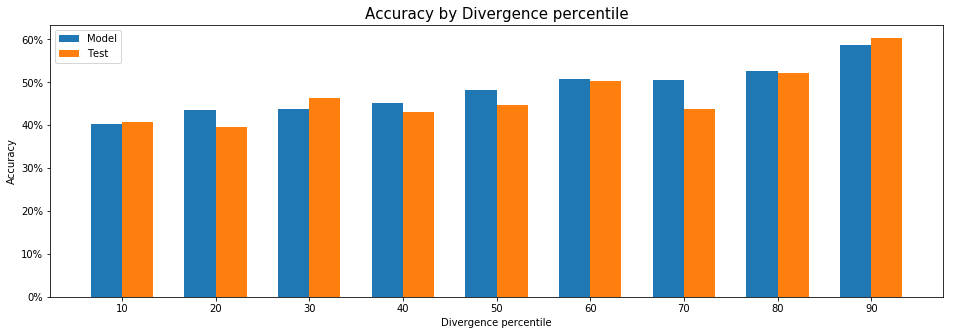

In [129]:
# Accuracy by divergence range

fig, ax = plt.subplots(figsize=[16,5])

#index = np.arange(len(labelList))
index = np.arange(10,(len(labelList)+1)*10,10)

bar_width = 3.33
plt.bar(index - bar_width/2, modelList, bar_width, label="Model")
plt.bar(index + bar_width/2, predictList, bar_width, label="Test")

ax.set_title("Accuracy by Divergence percentile", fontsize="15")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Divergence percentile")
#ax.set_ylim(0, 1)
ax.set_xticks(index)
vals = ax.get_yticks()
ax.set_yticklabels(["{:,.0%}".format(x) for x in vals])

ax.legend()
#ax.set_xticklabels()
plt.show()